# Balancing Exploration and Exploitation and Investigating Choice Perseveration in a Dynamic Two-Armed Bandit Task
Authors:<br>  Ana Carmen Angeles Torres, <br>  Victoria Eifert, <br> Elisa Hagensieker, <br> Pelin Kömürlüoglu
<br>

This Python notebook serves as a template for your group project on Experiment 1: Two-Armed Bandit Tasks for the course 'Modeling in Cognitive Science'.
This is the practical part of the group project where you get to implement the computational modeling workflow. In this part, you are expected to:


*   Implement at least two computational models relevant for your hypothesis. *(3 points)*
*   Simulate behavior from the two models. *(3 points)*
*   Implement a procedure for fitting the models to data. *(4 points)*
*   Implement a procedure for parameter recovery. *(5 points)*
*   (Implement a procedure for model recovery.) *(optional; 2 bonus points)*
*   Implement a model comparison. *(5 points)*.

You can gain a total of 20 points for the practical part of the group project.

**Note:** *Some of the exercises below (e.g. Model Simulation) rely on code from previous exercises (e.g., Model Implementation). In such cases, you are encouraged to rely on functions implemented for previous exercises. That is, you don't have to produce redundant code.*

For more information, you can check the task's GitHub repository:
[2 armed bandit task](https://github.com/snamazova/two_armed_bandit_task)



## Data Loading


In [ ]:
from data_loading import *

df = load_data()
df


ModuleNotFoundError: No module named 'google.colab'

### DataFrame Structure Overview

The DataFrame(df) contains multiple columns representing various aspects of a **two-armed bandit experiment**. Below is a breakdown of the key columns:  

## 1. General Trial Information  
- **`trial_index`**: The index of the current trial in the experiment (note: displaying the score is also considered a trial, as it is a stimulus).  
- **`trial_type`**: The type of trial, indicating how the response was made (e.g., via keyboard or mouse click).  
- **`time_elapsed`**: The total time elapsed (in milliseconds) since the start of the experiment.  
- **`internal_node_id`**: An internal identifier for the trial structure.  

## 2. Response and Stimulus Data  
- **`stimulus`**: The presented stimulus for the trial (a `<div>` tag containing the value and color of the bandit).  
- **`response`**: The participant’s response/input during the trial.  
- **`rt`**: The reaction time (in milliseconds) taken to respond.  

## 3. Task-Specific Information (Bean Task)    
- **`bean_trial_duration`**: The duration of the bean trial.  
- **`bean_duration`**: The time the bean stimulus was displayed.  
- **`bean_stimulus`**: The presented stimulus for the trial (a `<div>` tag containing the value and color of the bandit).  
- **`bean_choices`**: The available choice options in the trial.  
- **`bean_correct_key`**: The correct key (button press) for the task.  
- **`bean_type`**: The category of the bean stimulus.  
- **`bean_text`**: A text representation of the bean (if applicable).  
- **`bean_color`**: The color of the bean, which may be relevant to decision-making.  
- **`bean_correct`**: A boolean or categorical value indicating whether the response was correct.  
  - *Note:* In the bandit task, there is no strictly correct choice, as the task focuses on exploration rather than accuracy.  
- **`bean_value`**: The assigned value or reward associated with the bean (bandit).  
- **`bean_score`**: The accumulated score in the experiment.  

## 4. Additional Processing Data  
- **`bean_html_array`**: An HTML representation of the bean stimulus.  
- **`bean_values`**: An array containing value-related information for different beans.  
- **`bean_time_after_response`**: The time elapsed after the participant’s response.  
- **`bean_bandits`**: Information about Bandit 1 and Bandit 2 (their color and value).  


In [ ]:
processing_data(df)

# Exlporing the data

We now explore the key behavioral variables:
1. Choice proportions:
We observe how we shift preferences over time.
2. Reward rate:
We group trials into blocks and plot the average reward.
3. Switching behavior:
We compute the probability of switching actions to test if participants follow a win-stay and lose-switch pattern.
4. Reaction time:
We plot a histogra, of RTs.


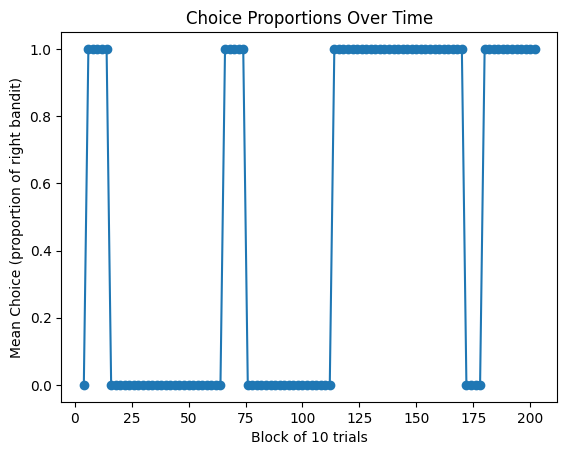

In [ ]:
from explore_data import *

plot_choices_over_time(df)

We can observe how the proportion of choosing one bandit changes over trials. There is always a longer phase of staying with one bandit.

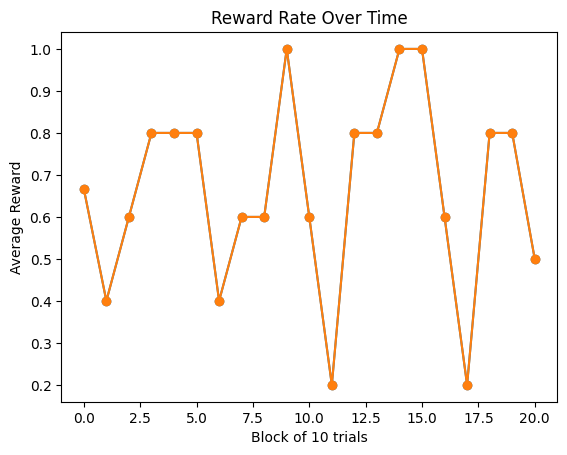

In [ ]:
df['block'] = df['trial_index'] // 10

reward_rate = df.groupby('block')['value'].mean()
plt.plot(reward_rate.index, reward_rate.values, marker='o')
plt.xlabel('Block of 10 trials')
plt.ylabel('Average Reward')
plt.title('Reward Rate Over Time')
plt.show()

This plot gives an indication of the overall performance across the experiment. Changes in reward might indicate adjustments in the behavior.

In [ ]:
df['prev_choice'] = df['response'].shift(1)
df = df.loc[:, ~df.columns.duplicated()]
df['prev_reward'] = df['value'].shift(1)

df['switch'] = (df['value'] != df['prev_choice']).astype(int)

# Switch rate after win:
switch_after_win = df.loc[df['prev_reward']==1, 'switch'].mean()
# Switch rate after loss:
switch_after_loss = df.loc[df['prev_reward']==0, 'switch'].mean()

print("Switch after Win:", switch_after_win)
print("Switch after Loss:", switch_after_loss)

Switch after Win: 0.4393939393939394
Switch after Loss: 0.5454545454545454


<ipython-input-13-d49a8c2ba414>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev_reward'] = df['value'].shift(1)


The values indicate the proportion of trials in which a particpant switches their choices after receiving a reward of 1 or zero reward. A higher switch rate after loss is common as we adjust our behavior.

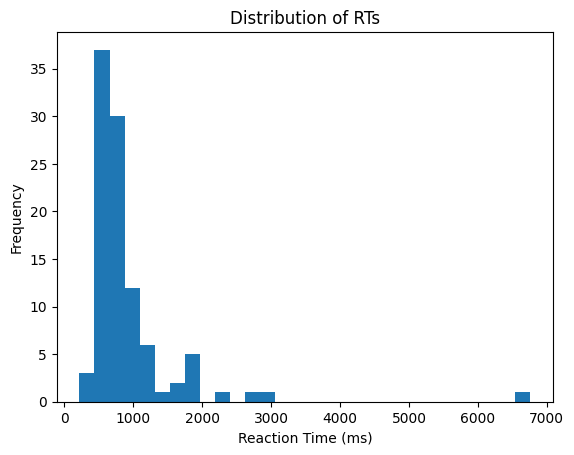

In [ ]:
plt.hist(df['rt'], bins=30)
plt.xlabel('Reaction Time (ms)')
plt.ylabel('Frequency')
plt.title('Distribution of RTs')
plt.show()

Overall, the reaction time is mostly around 800 ms with some outliers at 3000 and 7000 ms.

## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [ ]:
# YOUR MODEL IMPLEMENTATION CODE GOES HERE
class ModelBasedRL:
    def __init__(self, alpha = 0.1, beta = 5, gamma = 0.9):
        """
        Initialize the model-based RL model
        We consider:
        - Q-table is of size (2, 2) - two states and two actions
        - transition_probs: gives the probabilities of outcomes for each action.
        """
        self.alpha = alpha  # Learning rate
        self.beta = beta  # exploration-exploitation balance
        self.gamma = gamma  # Discount factor
        self.q_table = np.zeros((2,2))
        self.transition_probs = {
            0: (0.7, 0.3),
            1: (0.3, 0.7)
        }

    def get_action_probabilities(self, state):
        """
        Compute softmax probs for actions in the state
        Args:
            state (int): The current state we are in
        Return:
            softmax prob (array): Probability for choosing the action in the state
        """
        q_values = self.q_table[state, :]
        exp_values = np.exp(self.beta * q_values)
        return exp_values / np.sum(exp_values)

    def policy(self, state):
        """
        Sample an action using softmax probabilities
        Args:
            state (int): The current state
        Returns:
            int: The chosen action (0,1)
        """
        action_probs = self.get_action_probabilities(state)
        return np.random.choice([0, 1], p=action_probs)

    def update_q_table(self, state, action, reward,terminal):
        """
        Update the Q-value for the given state and action using the RPE.

        Args:
            state (int): The current state
            action (int): The action taken
            reward (float): The reward received
            terminal (bool): Whether the outcome is terminal
        """
        if terminal:
            rpe = reward - self.q_table[state, action]
        else:
            prob_s1, prob_s2 = self.transition_model[action]
            expected_q = prob_s1 * np.max(self.q_table[1, :]) + prob_s2 * np.max(self.q_table[2, :])
            rpe = reward + self.gamma * expected_q - self.q_table[state, action]

        self.q_table[state, action] += self.alpha * rpe


## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. The model plots should depict key features of the behavioral data, convincing yourself that the models are suitable to capture the data. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


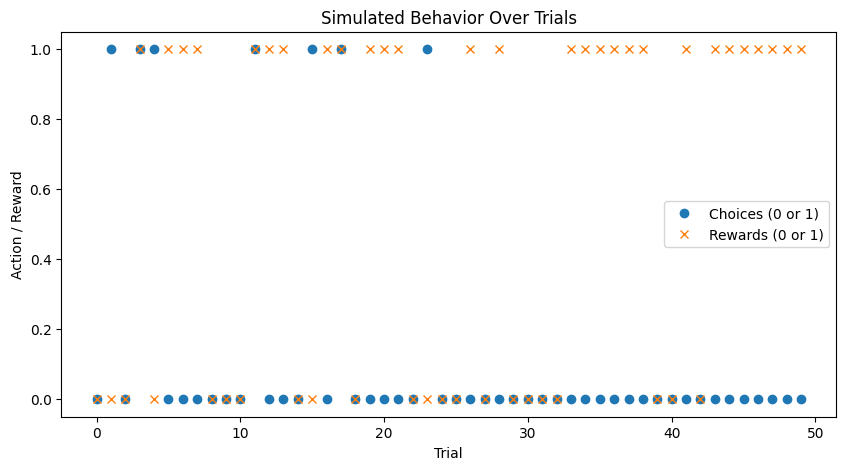

In [ ]:
np.random.seed(42)
choices, rewards, agent = simulate_participant(trials=50, alpha=0.1, beta=5, gamma=0.9)
plot_simulated_behavior(choices, rewards)

The simulated behavior plot shows the sequence of choices (which bandit was chosen) and the rewards received.
By visually comparing this to the empirical plots, we can get a sense of whether the model captures key patterns in the data.

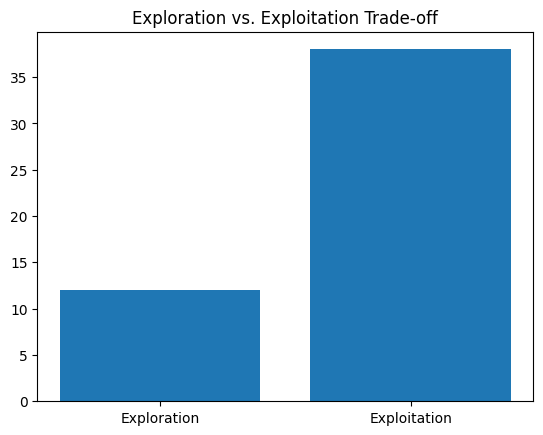

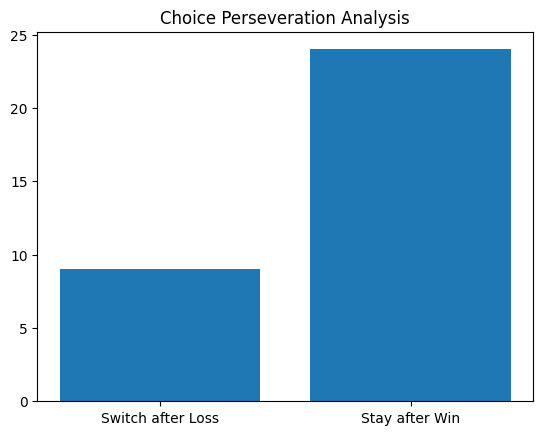

In [ ]:
# analyze exploration-exploitation tradeoff
exploration, exploitation = analyze_exploration_exploitation(choices)
plt.bar(['Exploration', 'Exploitation'], [exploration, exploitation])
plt.title('Exploration vs. Exploitation Trade-off')
plt.show()

# analyze choice-preservation
switch_loss, stay_win = analyze_choice_perseveration(choices, rewards)
plt.bar(['Switch after Loss', 'Stay after Win'], [switch_loss, stay_win])
plt.title('Choice Perseveration Analysis')
plt.show()


## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



In [ ]:
np.random.seed(42)
simulated_data = simulate_data_for_fitting()
optimized_params, best_likelihood = grid_search_parameter_fit(simulated_data)
print(f"Optimized Parameters: Alpha={optimized_params[0]}, Beta={optimized_params[1]}")
print(f"Best Log-Likelihood: {best_likelihood:.3f}")


Optimized Parameters: Alpha=0.2222222222222222, Beta=4.5
Best Log-Likelihood: -43.850


## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





We test whether our fitting procedure can recover known parameters.
We simulate data from multiple sets of randomly sampled parameters, fit the model,
and then evaluate the recovery with correlations and mean absolute error (MAE).

Alpha Correlation: 0.805, Alpha MAE: 0.125
Beta Correlation: 0.628, Beta MAE: 1.587


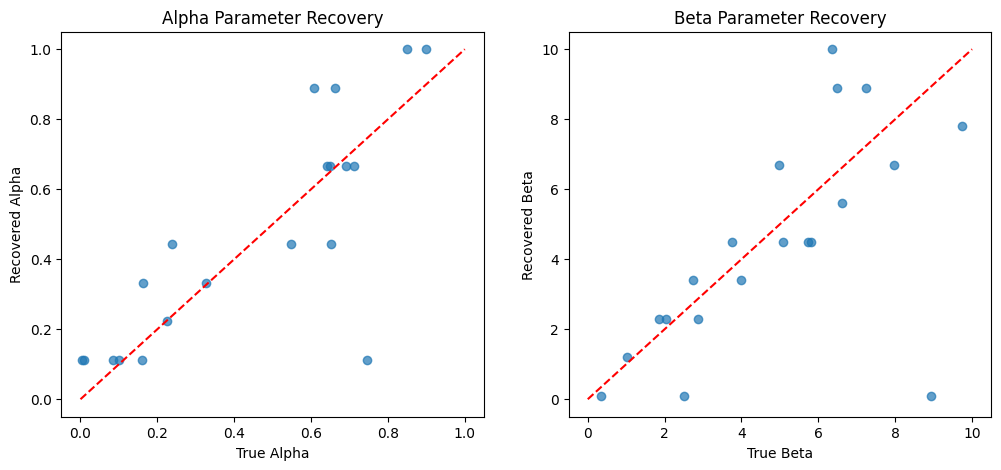

In [ ]:
# Run parameter recovery and evaluation
true_params, recovered_params = parameter_recovery()
evaluate_parameter_fit(true_params, recovered_params)
plot_param_recovery(true_params, recovered_params)


## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [ ]:
# YOUR MODEL RECOVERY CODE GOES HERE

## Model Comparison *(5 points)*

For this exercise you should:

*   Load and (potentially) preprocess the experimental data. (1 point)

*   Fit the two models to the data.  *(1 point)*

*   Evaluate which model performs better, taking into account fit and model complexity. *(2 points)*

*   Plot the behavior of the winning model against the data. *(1 point)**

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [ ]:
# YOUR MODEL COMPARISON CODE GOES HERE